In [1]:
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
np.random.seed(0)

# Introduction

This notebook investigates deep linear networks as described in *"Exact solution to the nonlinear dynamics of learning in deep linear neural networks"* by Andrew Saxe, James McClelland, and Surya Ganguli.

The notebook has three parts:
1. In part 1, we explain gradient descent and implement the trainable linear network.
2. In part 2, we train the linear network to solve an MNIST classification task.
3. In part 3, we test the claims made by Saxe et al. about dynamical isometry.

# Part 1: Gradient descent

### The data

We want a linear network to approximate a **target function** $f$ which maps $N$-vectors to $M$-vectors. 

To program the network we need a **dataset** of examples of the input-output mapping $\mathcal D = x^\mu, y^\mu$ for $\mu = 1, 2 \dots P$.

We take $X$ as the first 100 (whitened) columns of the first 50000 MNIST examples, and $Y$ as a one-hot coded category label.

In [2]:
X, Y = pd.read_pickle('mnist.pkl')
X = X[:50000]
Y = Y[:50000]
X = X - X.mean(axis=0)
U, S, VT = np.linalg.svd(X.T @ X)
X = X @ VT[:100].T
X = X / np.std(X, axis=0)

### The network

The architecture of an $L$-layer linear network is described by the layer sizes $(N_0, N_1 \dots N_L)$.

In this convention, layer $0$ assumes the value of the input vector and layer $L$ assumes the output values.

The network computes a **programmable mapping** $g$ parameterized by the matrices $(W_1, W_2 \dots W_L)$.

$W^l$ is a $N_l \times N_{l - 1}$ matrix that maps vectors from layer $l - 1$ to $l$.

The network computes the function

$$g(X) = X {W_1}^T {W_2}^T \dots {W_L}^T$$

when applied to matrix $X$ with input vectors $x$ on its rows.

In [3]:
def forward(X, Wl):
    Xl = [X]
    for W in Wl:
        X = X @ W.T
        Xl.append(X)
    gX = Xl[-1]
    return gX, Xl

### The objective

Now, we want to optimize $g$ for approximating the target mapping $f$ over the dataset $\mathcal D$.

To do this we define an **objective function $\mathcal L$** that outputs a quantity called the loss.

Then the goal of gradient descent is to find $(W^1, W^2 \dots W^L)$ that minimize the loss given $\mathcal D$.

We choose **mean squared error** as the loss, where error $E = f(X) - g(X)$:

In [4]:
def loss(fX, gX):
    return np.mean((fX - gX) ** 2)

### Computing gradients

Observe that $\frac{dL}{dE} = 2 \cdot E$ and $\frac{dE}{dg} = -1$.

Then dropping a constant $2$ and denoting activation at the output layer $X_L$,

$$\frac{d\mathcal L}{dX_L} = g(X) - f(X).$$

Since layer $l$ computes $X_{l-1} {W_l}^T$, the gradient of its output with respect to its input is $W^T$.

Then denoting activations at layer $l$ as $X_l$,

$$\frac{dX_l}{dX_{l - 1}} = {W_l}^T$$

Likewise, the gradient of its weight matrix ${W_l}^T$ with respect its output is $X_{l-1}$, the layer's input:

$$\frac{dX_l}{{dW_l}^T} = {X_{l - 1}}.$$

Using these equations we can propagate gradients backward from the loss to any part of the network.

We stop at each layer $l$ and compute the gradients of $\mathcal L$ with respect $W_l$ using that layer's activation:

$$\frac{d\mathcal L}{dW_l^T} = \frac{d\mathcal L}{dX_L} \frac{dX_L}{dX_{L-1}} \dots \frac{dX_{l+1}}{dX_l} \frac{dX_l}{dW_l^T}$$

In [5]:
def backward(fX, Wl, Xl):
    E = fX - Xl.pop()
    dLdg = -2 * E
    dLdWl = []
    for W in Wl[::-1]:
        X = Xl.pop()
        dLdW = np.sum(dLdg[:, :, np.newaxis] * X[:, np.newaxis, :], axis=0)
        dLdg = np.sum(dLdg[:, :, np.newaxis] * W[np.newaxis, :, :], axis=1)
        dLdWl.append(dLdW)
    return dLdWl[::-1]

### Stepwise update

Gradient descent iteratively updates $(W^1, W^2 \dots W^L)$ in a manner that reduces $\mathcal L$.

This is achieved by applying the **update rule**

$$d W_l = -\lambda \cdot \frac{d\mathcal L}{dW_l}$$

where $\lambda$ is a small learning rate.

Each step of gradient descent updates each weight matrix slightly in a direction opposite to its gradient with respect to the loss.

This reduces $g$'s actual error at approximating $f$ on $X$ and expected error at approximating $f$ on an input distribution like $X$.

In [6]:
def update(Wl, dLdWl, lr):
    for W, dLdW in zip(Wl, dLdWl):
        W -= lr * dLdW

# Part 2: Solving a task

Can a linear network learn to classify MNIST digits using the $\arg \max$ decision rule?

In [7]:
def accuracy(fX, gX):
    return np.mean(np.argmax(fX, axis=1) == np.argmax(gX, axis=1))

### Training a small network

We initialize a small network, drawing the weights as norm-preserving random projections.

In [8]:
def initialize_W(Nl):
    Wl = []
    for Nin, Nout in zip(Nl[:-1], Nl[1:]):
        W = np.random.randn(Nout, Nin)
        W /= np.linalg.norm(W, axis=1, keepdims=True)
        Wl.append(W)
    return Wl

# 2-layer linear network with 32 hidden units
Nl = [100, 32, 10]
Wl = initialize_W(Nl)
t = 0

Before any training, the network's accuracy is around 10% (chance):

In [9]:
gX = forward(X, Wl)[0]
print(f"loss(t={t}): {loss(Y, gX):.6f}, accuracy(t={t}): {accuracy(Y, gX)}")

loss(t=0): 1.084646, accuracy(t=0): 0.11672


Training one step decreases the loss and raises the accuracy:

In [10]:
dLdWl = backward(Y, Wl, forward(X, Wl)[-1])
update(Wl, dLdWl, lr=1e-6)
t += 1

gX = forward(X, Wl)[0]
print(f"loss(t={t}): {loss(Y, gX):.6f}, accuracy(t={t}): {accuracy(Y, gX)}")

loss(t=1): 0.660134, accuracy(t=1): 0.13232


Now, we train the network for 9 more steps:

In [11]:
for i in range(9):
    dLdWl = backward(Y, Wl, forward(X, Wl)[-1])
    update(Wl, dLdWl, lr=1e-6)
    t += 1

gX = forward(X, Wl)[0]
print(f"loss(t={t}): {loss(Y, gX):.6f}, accuracy(t={t}): {accuracy(Y, gX)}")

loss(t=10): 0.128222, accuracy(t=10): 0.37348


The accuracy is improving. Train 90 more steps:

In [12]:
for i in tqdm(range(90)):
    dLdWl = backward(Y, Wl, forward(X, Wl)[-1])
    update(Wl, dLdWl, lr=1e-6)
    t += 1

gX = forward(X, Wl)[0]
print(f"loss(t={t}): {loss(Y, gX):.6f}, accuracy(t={t}): {accuracy(Y, gX)}")

  0%|          | 0/90 [00:00<?, ?it/s]

loss(t=100): 0.057693, accuracy(t=100): 0.83352


After 100 steps of gradient descent the accuracy is **above 80%**. Therefore the linear network learns to solve a task.

### One weird trick...

Saxe et. al introduce a special trick for training **very deep** linear networks quickly.

They backpropagate error between the estimated and true input-output *covariance* rather than the estimated vs. true output.

This allows us to compute a backward pass on $X$ and $Y$ covariance matrices *instead of the full dataset* $\mathcal D$, greatly speeding up training.

In [13]:
CXX = X.T @ X / len(X)
CYX = Y.T @ X / len(Y)

def backward(Wl, CXX, CYX):
    fwdmap = [Wl[0].T]
    bwdmap = [Wl[-1].T]
    for i in range(len(Wl) - 1):
        fwdmap.append(fwdmap[-1] @ Wl[i + 1].T)
        bwdmap.insert(0, Wl[-i - 2].T @ bwdmap[0])

    dLdg = fwdmap[-1].T @ CXX - CYX
    dLdWl = []
    for i, W in enumerate(Wl):
        if i == 0:
            dLdW = bwdmap[1] @ dLdg
        elif i == len(Wl) - 1:
            dLdW = dLdg @ fwdmap[i - 1]
        else:
            dLdW = bwdmap[i + 1] @ dLdg @ fwdmap[i - 1]
        dLdWl.append(dLdW)
    return dLdWl

Armed with this trick, we can train very deep networks for a fraction of the ordinary cost.

### Training a very deep network

Now we initialize a network with **100 layers**:

In [14]:
Nl = [100] + 100 * [32] + [10]
Wl = initialize_W(Nl)

t = 0
gX = forward(X, Wl)[0]
print(f"loss(t={t}): {loss(Y, gX):.6f}, accuracy(t={t}): {accuracy(Y, gX)}")

loss(t=0): 0.877237, accuracy(t=0): 0.08368


Again the initial accuracy is close to chance. We train for 1000 steps:

In [15]:
for i in range(1000):
    dLdWl = backward(Wl, CXX, CYX)
    update(Wl, dLdWl, lr=1e-3)
    t += 1

print(f"loss(t={t}): {loss(Y, forward(X, Wl)[0]):.6f}, accuracy(t={t}): {accuracy(Y, forward(X, Wl)[0])}")

loss(t=1000): 0.098888, accuracy(t=1000): 0.16786


The accuracy rises somewhat, more slowly than in the 2-layer network. We run 9000 more steps:

In [16]:
for i in tqdm(range(9000)):
    dLdWl = backward(Wl, CXX, CYX)
    update(Wl, dLdWl, lr=1e-3)
    t += 1

print(f"loss(t={t}): {loss(Y, forward(X, Wl)[0]):.6f}, accuracy(t={t}): {accuracy(Y, forward(X, Wl)[0])}")

  0%|          | 0/9000 [00:00<?, ?it/s]

loss(t=10000): 0.089055, accuracy(t=10000): 0.37322


After 10000 steps of training accuracy is **around 30%**.

It seems the network learns, but **converges slowly** due to its depth.

# Part 3: Testing dynamical isometry

Saxe, McClelland and Ganguli describe a special learning regime which occurs when

1. the network's input and output connectivity modes align with principle directions of the input and output distributions, and
2. the gain (change in mode strength) of an input-output mode pair remains $O(1)$ across network layers.

The authors call this regime **dynamical isometry** and claim that it is especially good for learning in that

1. gradient descent attracts networks to the dynamically isometric state, and
2. once the dynamics are isometric, they stay that way for the remainder of learning.

Allegedly, obtaining dynamical isometry makes convergence more rapid, especially for **very deep** networks.

### An experiment

We test this claim by training two 100-layer networks side by side: 

1. **network 1**: initialized with the random norm-preserving projections used above, and
2. **network 2**: initialized so that weight matrix rows are orthonormal.

The authors state that initialization strategy (2) confers dynamical isometry, while (1) does not.

If the claims about dynamical isometry are true, then **network 2 will learn faster than network 1**.

Let's run the experiment and see.

In [17]:
# both networks have 100 layers
Nl = [100] + 100 * [32] + [10]

# network 1: initialized with norm-preserving random projections
Wl1 = initialize_W(Nl)

# network 2: initialized with random orthonormal projections
Wl2 = []
for Nin, Nout in zip(Nl[:-1], Nl[1:]):
    W = np.random.randn(Nin, Nin)
    Q, R = np.linalg.qr(W)
    W = Q[:Nout, :Nin]
    Wl2.append(W)

We check each network's initial accuracy. Both start at chance.

In [18]:
t = 0
g1X = forward(X, Wl1)[0]
g2X = forward(X, Wl2)[0]
print(f"initial loss1(t={t}): {loss(Y, g1X):.6f}, accuracy1(t={t}): {accuracy(Y, g1X)}")
print(f"initial loss2(t={t}): {loss(Y, g2X):.6f}, accuracy2(t={t}): {accuracy(Y, g2X)}")

initial loss1(t=0): 0.326161, accuracy1(t=0): 0.11102
initial loss2(t=0): 1.107688, accuracy2(t=0): 0.08458


We train both networks for 10000 steps (just like the network in part 2). Every 100 steps we record the loss and accuracy.

In [19]:
results = []
for i in tqdm(range(100)):
    g1X = forward(X, Wl1)[0]
    g2X = forward(X, Wl2)[0]
    results.append({
        't': t,
        'loss1': loss(Y, g1X),
        'loss2': loss(Y, g2X),
        'acc1': accuracy(Y, g1X),
        'acc2': accuracy(Y, g2X),
    })
    for i in range(100):
        dLdWl = backward(Wl1, CXX, CYX)
        update(Wl1, dLdWl, lr=1e-3)
        dLdWl = backward(Wl2, CXX, CYX)
        update(Wl2, dLdWl, lr=1e-3)
        t += 1

print(f"loss1(t={t}): {loss(Y, g1X):.6f}, accuracy1(t={t}): {accuracy(Y, g1X)}")
print(f"loss2(t={t}): {loss(Y, g2X):.6f}, accuracy2(t={t}): {accuracy(Y, g2X)}")

  0%|          | 0/100 [00:00<?, ?it/s]

loss1(t=10000): 0.090007, accuracy1(t=10000): 0.34284
loss2(t=10000): 0.069998, accuracy2(t=10000): 0.69902


### Results

As in part 2, network 1 achieves about **30% accuracy** after 10000 steps.

Network 2, initialized with dynamical isometry, reaches **>60% accuracy** in the same time.

Clearly, network 2 learns faster than network 1 (see figure below). This result affirms the claims about dynamical isometry.

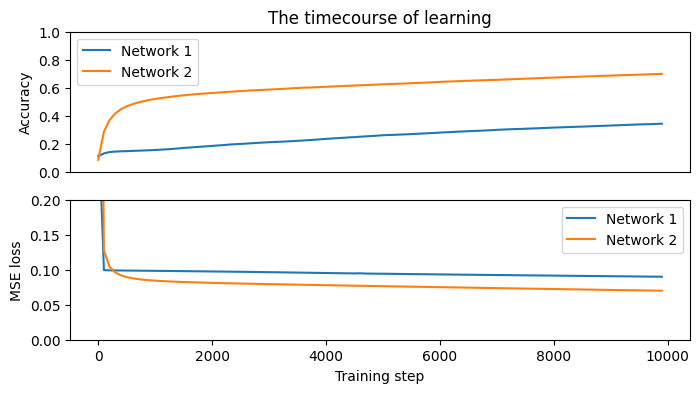

In [20]:
df = pd.DataFrame(results)
plt.figure(figsize=(8, 4))

plt.subplot(2, 1, 1)
plt.title('The timecourse of learning')
plt.ylabel('Accuracy')
plt.plot(df['t'], df['acc1'], label='Network 1')
plt.plot(df['t'], df['acc2'], label='Network 2')
plt.ylim([0, 1])
plt.xticks([], [])
plt.legend()

plt.subplot(2, 1, 2)
plt.ylabel('MSE loss')
plt.plot(df['t'], df['loss1'], label='Network 1')
plt.plot(df['t'], df['loss2'], label='Network 2')
plt.ylim([0, 0.2])
plt.xlabel('Training step')
plt.legend()
plt.show()

# Conclusion

In this notebook we investigated deep linear networks as described by Saxe et al. in *"Exact solution to the nonlinear dynamics of learning in deep linear neural networks."*

First, we derived the gradient descent update rule for the generalized linear network. Then we showed that the linear network can be trained to classifiy MNIST digits.

We implemented a computational trick to greatly speed up training, and showed that it can train a very deep network quickly. Using this trick, we performed an experiment testing dynamical isometry in very deep networks.

We found that initializing a network into dynamical isometry greatly speeds up training. This **confirmed** the claims by Saxe, McClelland and Ganguli. ∎